### Exploring the pixelpar Allen institute dataset

In this notebook we explore the dataset using the EcephysSession class provided by Allen Institute to load the data stored locally. For furter reference check the quick-start notebooks in [their website](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html) in which this notebook is based on.

In [1]:
import numpy             as np
import xarray            as xr
import pandas            as pd
import matplotlib.pyplot as plt

from tqdm                import tqdm

from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession
from allensdk.brain_observatory.ecephys.visualization   import plot_mean_waveforms, plot_spike_counts, raster_plot

pd.set_option("display.max_columns", None)

### Defining dicitionary with regions and areas' names

In [2]:
region_dict = {'cortex' :   ['VISp', 'VISl', 'VISrl', 'VISam', 'VISpm', 'VIS', 'VISal','VISmma','VISmmp','VISli'],
               'thalamus' : ['LGd','LD', 'LP', 'VPM', 'TH', 'MGm','MGv','MGd','PO','LGv','VL',
                             'VPL','POL','Eth','PoT','PP','PIL','IntG','IGL','SGN','VPL','PF','RT'],
               'hippocampus' : ['CA1', 'CA2','CA3', 'DG', 'SUB', 'POST','PRE','ProS','HPF'],
               'midbrain':     ['MB','SCig','SCiw','SCsg','SCzo','PPT','APN','NOT','MRN','OP','LT','RPF','CP']}

color_dict = {'cortex' :      '#08858C',
              'thalamus' :    '#FC6B6F',
              'hippocampus' : '#7ED04B',
              'midbrain' :    '#FC9DFE'}

### Reading the data stored localy

`EcephysSession` objects contain methods and properties that access the data within an ecephys NWB file and cache it in memory.

In [3]:
nwb_path = '../data/ecephys_cache_dir/session_756029989/ecephys_session_756029989.nwb'

session = EcephysSession.from_nwb_path(nwb_path, api_kwargs={
                                       "amplitude_cutoff_maximum": np.inf,
                                       "presence_ratio_minimum":  -np.inf,
                                       "isi_violations_maximum":   np.inf
                                       })
'''
session = EcephysSession.from_nwb_path(nwb_path)
'''

'\nsession = EcephysSession.from_nwb_path(nwb_path)\n'

This session object has some important metadata, such as the date and time at which the recording session started:

In [4]:
print(f"session {session.ecephys_session_id} was acquired in {session.session_start_time}")

session 756029989 was acquired in 2018-10-26 12:59:18-07:00


We'll now jump in to accessing our session's data. If you ever want a complete documented list of the attributes and methods defined on `EcephysSession`, you can run `help(EcephysSession)` (or in a jupyter notebook: `EcephysSession?`).

### Sorted units

Units are putative neurons, clustered from raw voltage traces using Kilosort 2. Each unit is associated with a single *peak channel* on a single probe, though its spikes might be picked up with some attenuation on multiple nearby channels. Each unit is assigned a unique integer identifier ("unit_id") which can be used to look up its  spike times and its mean waveform.

The units for a session are recorded in an attribute called, fittingly, `units`. This is a `pandas.DataFrame` whose index is the unit id and whose columns contain summary information about the unit, its peak channel, and its associated probe.

In [5]:
session.units.head()

,L_ratio,presence_ratio,d_prime,waveform_halfwidth,cluster_id,firing_rate,peak_channel_id,silhouette_score,waveform_repolarization_slope,waveform_amplitude,snr,waveform_velocity_below,max_drift,nn_miss_rate,nn_hit_rate,waveform_velocity_above,waveform_spread,amplitude_cutoff,waveform_duration,waveform_PT_ratio,cumulative_drift,isolation_distance,isi_violations,waveform_recovery_slope,local_index_unit,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_acronym,probe_vertical_position,probe_horizontal_position,probe_id,channel_local_index,ecephys_structure_id,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951814824,0.000162,0.99,6.568869,0.178559,0,29.494252,850126376,NaN,0.699909,160.663425,3.549688,NaN,38.62,0.000000,0.999333,1.030151,30.0,0.106795,0.274707,0.534119,405.61,118.211976,0.007482,-0.142738,0,8173.0,3510.0,3510.0,APN,20,11,760640083,1,215.0,probeA,See electrode locations,29999.949611,1249.9979,True
951814867,0.038154,0.94,2.488505,0.096147,3,8.880075,850126378,0.029825,0.744335,199.406025,3.212428,NaN,29.53,0.022137,0.653333,-0.343384,30.0,0.500000,0.164824,0.529991,353.76,33.707586,0.150292,-0.250084,3,8169.0,3502.0,3502.0,APN,40,59,760640083,2,215.0,probeA,See electrode locations,29999.949611,1249.9979,True
951814858,0.018218,0.78,3.550667,0.151089,2,21.718427,850126378,0.029572,0.638518,142.008360,2.562872,NaN,30.39,0.021401,0.883333,0.686767,20.0,0.047903,0.233501,0.511884,464.61,65.522935,0.026082,-0.130377,2,8169.0,3502.0,3502.0,APN,40,59,760640083,2,215.0,probeA,See electrode locations,29999.949611,1249.9979,True
951814846,0.049880,0.94,2.240600,0.137353,1,10.959691,850126378,0.260802,0.722769,164.262345,2.889579,NaN,24.18,0.032962,0.605333,-0.343384,30.0,0.390901,0.233501,0.512634,306.75,32.912741,0.400619,-0.174961,1,8169.0,3502.0,3502.0,APN,40,59,760640083,2,215.0,probeA,See electrode locations,29999.949611,1249.9979,True
951814903,0.036772,0.66,2.537557,0.123618,8,0.546655,850126384,0.081693,0.594654,132.940860,2.248297,-0.686767,76.03,0.001405,0.361905,-0.343384,90.0,0.024339,0.219765,0.308099,571.28,24.666971,0.251799,-0.071989,7,8158.0,3480.0,3480.0,APN,60,11,760640083,5,215.0,probeA,See electrode locations,29999.949611,1249.9979,True


As a `pandas.DataFrame` the units table supports many straightforward filtering operations:

In [6]:
# how many units have signal to noise ratios that are greater than 4?
print(f'{session.units.shape[0]} units total.')
units_with_very_high_snr = session.units[session.units['snr'] > 4]
print(f'{units_with_very_high_snr.shape[0]}  units have SNR > 4.')

1641 units total.
131  units have SNR > 4.


### Stimulus presentations

During the course of a session, visual stimuli are presented on a monitor to the subject. We call intervals of time where a specific stimulus is presented (and its parameters held constant!) a *stimulus presentation*.

You can find information about the stimulus presentations that were displayed during a session by accessing the `stimulus_presentations` attribute on your `EcephysSession` object. 

In [7]:
session.stimulus_presentations.head()

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,24.429348,null,spontaneous,84.496188,null,null,null,60.066840,0
1,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.496188,0,gabors,84.729704,4,40,30,0.233516,1
2,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.729704,0,gabors,84.979900,4,-30,10,0.250196,2
3,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.979900,0,gabors,85.230095,4,10,-10,0.250196,3
4,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.230095,0,gabors,85.480291,4,30,40,0.250196,4


Like the units table, this is a `pandas.DataFrame`. Each row corresponds to a stimulus presentation and lists the time (on the session's master clock, in seconds) when that presentation began and ended as well as the kind of stimulus that was presented (the "stimulus_name" column) and the parameter values that were used for that presentation. Many of these parameter values don't overlap between stimulus classes, so the stimulus_presentations table uses the string `"null"` to indicate an inapplicable parameter. The index is named "stimulus_presentation_id" and many methods on `EcephysSession` use these ids.

Some of the columns bear a bit of explanation:
- stimulus_block : A block consists of multiple presentations of the same stimulus class presented with (probably) different parameter values. If during a session stimuli were presented in the following order:
    - drifting gratings
    - static gratings
    - drifting gratings
    then the blocks for that session would be [0, 1, 2]. The gray period stimulus (just a blank gray screen) never gets a block.
- duration : this is just stop_time - start_time, precalculated for convenience.

What kinds of stimuli were presented during this session? Pandas makes it easy to find out:

In [8]:
session.stimulus_names # just the unique values from the 'stimulus_name' column

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

We can also obtain the `stimulus epochs` - blocks of time for which a particular kind of stimulus was presented - for this session.

In [9]:
session.get_stimulus_epochs()

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,24.429348,84.496188,60.066840,spontaneous,null
1,84.496188,996.491813,911.995625,gabors,0
2,996.491813,1285.483398,288.991585,spontaneous,null
3,1285.483398,1583.982946,298.499548,flashes,1
4,1583.982946,1585.734418,1.751472,spontaneous,null
5,1585.734418,2185.235561,599.501143,drifting_gratings,2
6,2185.235561,2216.261498,31.025937,spontaneous,null
7,2216.261498,2816.763498,600.502000,natural_movie_three,3
8,2816.763498,2846.788598,30.025100,spontaneous,null
9,2846.788598,3147.039578,300.250980,natural_movie_one,4


If you are only interested in a subset of stimuli, you can either filter using pandas or using the `get_stimulus_table` convience method:

In [10]:
session.get_stimulus_table(['drifting_gratings']).head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,180,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1585.734418,2,drifting_gratings,1587.736098,2,2.00168,246
3799,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1588.736891,2,drifting_gratings,1590.738571,2,2.00168,247
3800,0.8,180,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1591.739398,2,drifting_gratings,1593.741078,2,2.00168,246
3801,0.8,270,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1594.741921,2,drifting_gratings,1596.743591,2,2.00167,248
3802,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1597.744458,2,drifting_gratings,1599.746088,4,2.00163,249


We might also want to know what the total set of available parameters is. The `get_stimulus_parameter_values` method provides a dictionary mapping stimulus parameters to the set of values that were applied to those parameters:

In [11]:
for key, values in session.get_stimulus_parameter_values().items():
    print(f'{key}: {values}')

color: [-1.0 1.0]
contrast: [0.8 1.0]
frame: [-1.0 0.0 1.0 ... 3597.0 3598.0 3599.0]
orientation: [0.0 30.0 45.0 60.0 90.0 120.0 135.0 150.0 180.0 225.0 270.0 315.0]
phase: ['0.0' '0.25' '0.5' '0.75' '[0.0, 0.0]' '[3644.93333333, 3644.93333333]'
 '[42471.86666667, 42471.86666667]']
size: ['[1920.0, 1080.0]' '[20.0, 20.0]' '[250.0, 250.0]' '[300.0, 300.0]']
spatial_frequency: ['0.02' '0.04' '0.08' '0.16' '0.32' '[0.0, 0.0]']
temporal_frequency: [1.0 2.0 4.0 8.0 15.0]
x_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]
y_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]


Each distinct state of the monitor is called a "stimulus condition". Each presentation in the stimulus presentations table exemplifies such a condition. This is encoded in its stimulus_condition_id field.

To get the full list of conditions presented in a session, use the stimulus_conditions attribute:

In [12]:
session.stimulus_conditions.head()

,color,contrast,frame,mask,opacity,orientation,phase,size,spatial_frequency,stimulus_name,temporal_frequency,units,x_position,y_position,color_triplet
stimulus_condition_id,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,null,null,spontaneous,null,null,null,null,null
1,null,0.8,null,circle,1,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,40,30,"[1.0, 1.0, 1.0]"
2,null,0.8,null,circle,1,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,-30,10,"[1.0, 1.0, 1.0]"
3,null,0.8,null,circle,1,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,10,-10,"[1.0, 1.0, 1.0]"
4,null,0.8,null,circle,1,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,30,40,"[1.0, 1.0, 1.0]"


### Spike data

The `EcephysSession` object holds spike times (in seconds on the session master clock) for each unit. These are stored in a dictionary, which maps unit ids (the index values of the units table) to arrays of spike times.

In [13]:
 # grab an arbitrary (though high-snr!) unit (we made units_with_high_snr above)
high_snr_unit_ids = units_with_very_high_snr.index.values
unit_id           = high_snr_unit_ids[0]

print(f"{len(session.spike_times[unit_id])} spikes were detected for unit {unit_id} at times:")
session.spike_times[unit_id]

/home/vinicius/anaconda3/lib/python3.8/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1093: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


344 spikes were detected for unit 951818119 at times:


array([ 651.18433803,  661.85908929,  661.87392265,  661.91182271,
        661.92135606,  661.98948951,  662.01088954,  676.1529133 ,
        676.16704665,  676.17981334,  706.86086488, 1125.61296823,
       1184.02493301, 1207.64770602, 1207.8764064 , 1223.32776569,
       1433.62618558, 1461.25223199, 1599.38849734, 1602.68596954,
       1602.82983645, 1803.60737369, 1911.49092156, 2095.70273097,
       2113.28342717, 2114.10699522, 2171.29842461, 2281.15024246,
       2288.89692213, 2288.92802219, 2288.9332222 , 2288.97022226,
       2288.98095561, 2295.99190072, 2296.06613418, 2296.07950087,
       2360.21637526, 2386.98945356, 2565.84885398, 2625.11015352,
       2627.78632468, 2729.89019618, 2732.02446643, 2732.03669979,
       2732.04846647, 2732.05683315, 2732.06503317, 2732.13933329,
       2732.17610002, 2732.26856684, 2732.27710019, 2732.35280032,
       2732.42893378, 2732.49663389, 2732.51683392, 2732.53780063,
       2732.56300067, 2732.57380069, 2732.58783404, 2732.60220

You can also obtain spikes tagged with the stimulus presentation during which they occurred:

In [14]:
# get spike times from the first block of drifting gratings presentations 
drifting_gratings_presentation_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings')
].index.values

times = session.presentationwise_spike_times(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=session.units.index.values
)

times.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1585.734521,3798,951801384,0.000103
1585.734628,3798,951820473,0.000210
1585.734695,3798,951819406,0.000277
1585.734825,3798,951805355,0.000407
1585.734841,3798,951817927,0.000423


In [15]:
print(drifting_gratings_presentation_ids)

[ 3798  3799  3800  3801  3802  3803  3804  3805  3806  3807  3808  3809
  3810  3811  3812  3813  3814  3815  3816  3817  3818  3819  3820  3821
  3822  3823  3824  3825  3826  3827  3828  3829  3830  3831  3832  3833
  3834  3835  3836  3837  3838  3839  3840  3841  3842  3843  3844  3845
  3846  3847  3848  3849  3850  3851  3852  3853  3854  3855  3856  3857
  3858  3859  3860  3861  3862  3863  3864  3865  3866  3867  3868  3869
  3870  3871  3872  3873  3874  3875  3876  3877  3878  3879  3880  3881
  3882  3883  3884  3885  3886  3887  3888  3889  3890  3891  3892  3893
  3894  3895  3896  3897  3898  3899  3900  3901  3902  3903  3904  3905
  3906  3907  3908  3909  3910  3911  3912  3913  3914  3915  3916  3917
  3918  3919  3920  3921  3922  3923  3924  3925  3926  3927  3928  3929
  3930  3931  3932  3933  3934  3935  3936  3937  3938  3939  3940  3941
  3942  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  3953
  3954  3955  3956  3957  3958  3959  3960  3961  3

We can make raster plots of these data:

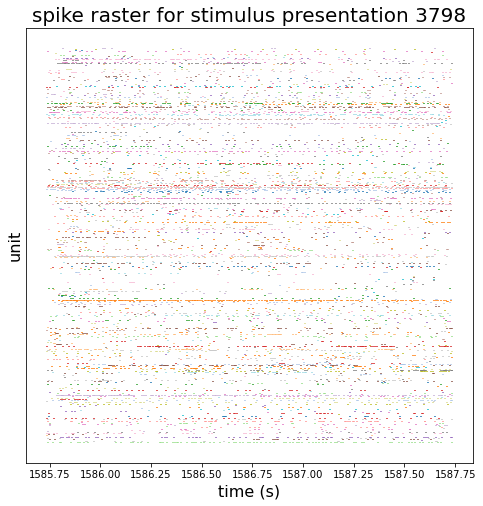

color                                                null
contrast                                              0.8
frame                                                null
orientation                                           180
phase                    [42471.86666667, 42471.86666667]
size                                       [250.0, 250.0]
spatial_frequency                                    0.04
start_time                                        1585.73
stimulus_block                                          2
stimulus_name                           drifting_gratings
stop_time                                         1587.74
temporal_frequency                                      2
x_position                                           null
y_position                                           null
duration                                          2.00168
stimulus_condition_id                                 246
Name: 3798, dtype: object

In [16]:
first_drifting_grating_presentation_id = times['stimulus_presentation_id'].values[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]

fig = raster_plot(plot_times, title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')
plt.show()

# also print out this presentation
session.stimulus_presentations.loc[first_drifting_grating_presentation_id]

In [17]:
plot_times.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1585.734521,3798,951801384,0.000103
1585.734628,3798,951820473,0.000210
1585.734695,3798,951819406,0.000277
1585.734825,3798,951805355,0.000407
1585.734841,3798,951817927,0.000423


We can also plot the whole raster plot and color each spike-train accordingly to its brain region

In [18]:
units = session.units

Text(0, 0.5, 'ID')

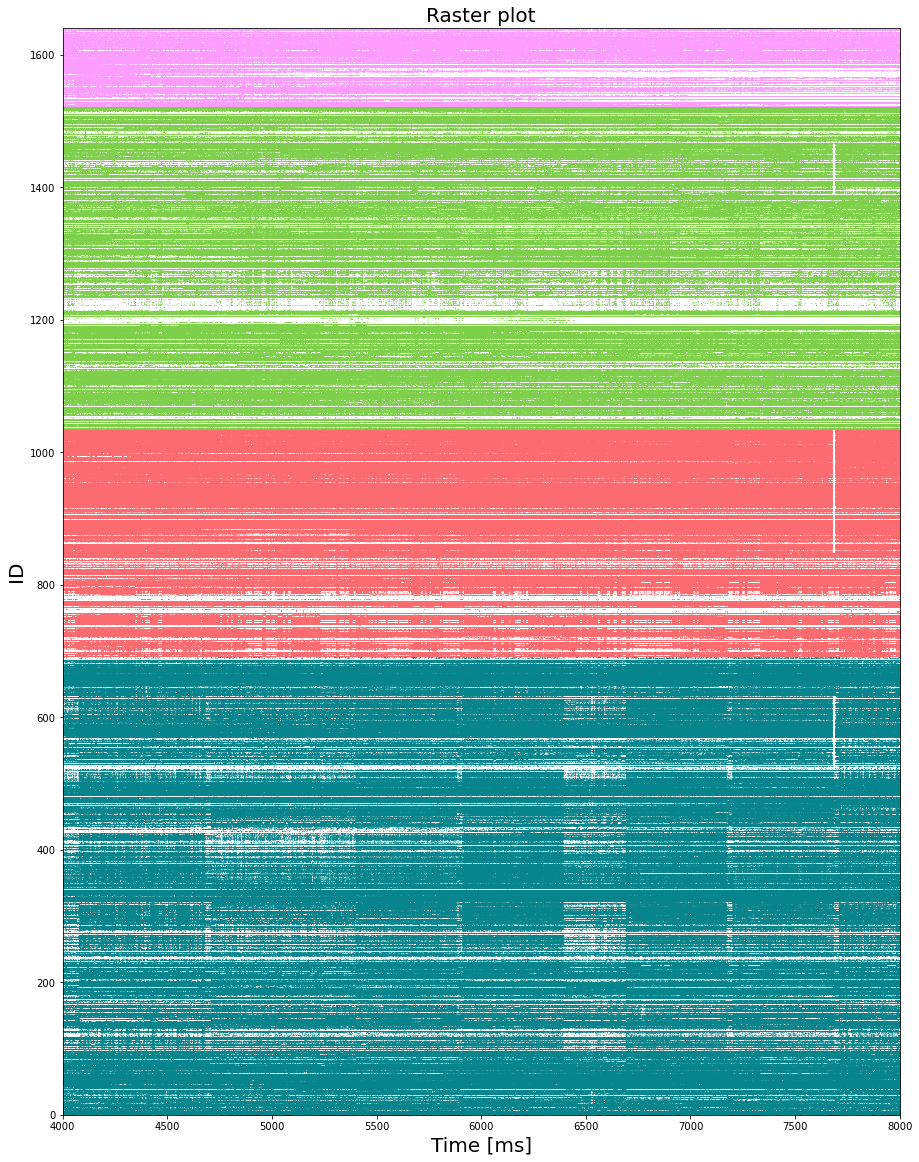

In [19]:
plt.figure(figsize=(15,20))
count = 0
for idx, region in enumerate(region_dict.keys()):
    ids = units[units.ecephys_structure_acronym.isin(region_dict[region])].index.values
    for i in ids:
        plt.plot(session.spike_times[i], [count]*len(session.spike_times[i]), '|', ms=.3, color = color_dict[region])
        count += 1
plt.xlim([4000,8000])
plt.ylim([0,count])
plt.title('Raster plot', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.ylabel('ID', fontsize=20)
#plt.savefig('img/raster_plot_session_721123822.png', dpi=150)

### Suggested exercises

If you would hands-on experience with the `EcephysSession` class, please consider working through some of these excercises.

- **tuning curves** : Pick a stimulus parameter, such as orientation on drifting gratings trials. Plot the mean and standard error of spike counts for each unit at each value of this parameter.
- **signal correlations** : Calculate unit-pairwise correlation coefficients on the tuning curves for a stimulus parameter of interest (`numpy.corrcoef` might be useful).
- **noise correlations** : Build for each unit a vector of spike counts across repeats of the same stimulus condition. Compute unit-unit correlation coefficients on these vectors.
- **cross-correlations** : Start with two spike trains. Call one of them "fixed" and the other "moving". Choose a set of time offsets and for each offset:
    1. apply the offset to the spike times in the moving train
    2. compute the correlation coefficient between the newly offset moving train and the fixed train.
    You should then be able to plot the obtained correlation coeffients as a function of the offset. 
- **unit clustering** : First, extract a set of unitwise features. You might draw these from the mean waveforms, for instance:
    - mean duration between waveform peak and trough (on the unit's peak channel)
    - the amplitude of the unit's trough
    
    or you might draw them from the unit's spike times, such as:
    - median inter-spike-interval
    
    or from metadata
    - CCF structure
    
    With your features in hand, attempt an unsupervised classification of the units. If this seems daunting, check out the [scikit-learn unsupervised learning documention](https://scikit-learn.org/stable/modules/clustering.html#clustering) for library code and examples.
- **population decoding** : Using an `EcephysSession` (and filtering to some stimuli and units of interest), build two aligned matrices:
    1. A matrix whose rows are stimulus presentations, columns are units, and values are spike counts.
    2. A matrix whose rows are stimulus presentations and whose columns are stimulus parameters.
    
    Using these matrices, train a classifier to predict stimulus conditions (sets of stimulus parameter values) from presentationwise population spike counts. See the [scikit-learn supervised learning tutorial](https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html) for a guide to supervised learning in Python.

#### 1. Tuning Curves

Pick a stimulus parameter, such as orientation on drifting gratings trials. Plot the mean and standard error of spike counts for each unit at each value of this parameter.

In [20]:
# Printing stimulus informations
session.stimulus_conditions.head()

,color,contrast,frame,mask,opacity,orientation,phase,size,spatial_frequency,stimulus_name,temporal_frequency,units,x_position,y_position,color_triplet
stimulus_condition_id,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,null,null,spontaneous,null,null,null,null,null
1,null,0.8,null,circle,1,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,40,30,"[1.0, 1.0, 1.0]"
2,null,0.8,null,circle,1,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,-30,10,"[1.0, 1.0, 1.0]"
3,null,0.8,null,circle,1,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,10,-10,"[1.0, 1.0, 1.0]"
4,null,0.8,null,circle,1,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,30,40,"[1.0, 1.0, 1.0]"


In [21]:
session.stimulus_presentations.head()

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,24.429348,null,spontaneous,84.496188,null,null,null,60.066840,0
1,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.496188,0,gabors,84.729704,4,40,30,0.233516,1
2,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.729704,0,gabors,84.979900,4,-30,10,0.250196,2
3,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.979900,0,gabors,85.230095,4,10,-10,0.250196,3
4,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.230095,0,gabors,85.480291,4,30,40,0.250196,4


In [22]:
filtered_stim_table = session.get_stimulus_table(stimulus_names=['drifting_gratings'], 
                                                 include_detailed_parameters=True)

In [23]:
filtered_stim_table.head()

,contrast,mask,opacity,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,units,color_triplet,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
3798,0.8,None,1,180,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1585.734418,2,drifting_gratings,1587.736098,2,deg,"[1.0, 1.0, 1.0]",2.00168,246
3799,0.8,None,1,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1588.736891,2,drifting_gratings,1590.738571,2,deg,"[1.0, 1.0, 1.0]",2.00168,247
3800,0.8,None,1,180,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1591.739398,2,drifting_gratings,1593.741078,2,deg,"[1.0, 1.0, 1.0]",2.00168,246
3801,0.8,None,1,270,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1594.741921,2,drifting_gratings,1596.743591,2,deg,"[1.0, 1.0, 1.0]",2.00167,248
3802,0.8,None,1,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1597.744458,2,drifting_gratings,1599.746088,4,deg,"[1.0, 1.0, 1.0]",2.00163,249


In [24]:
# IDs of drigiting gratings 
ids          = filtered_stim_table.index.values
# Orientation of the stimulus for each ID 
orientations = filtered_stim_table.orientation.values
# Duration of the presentation
durations    = filtered_stim_table.duration

In [25]:
# Remove values for "null" orientations
ids          = ids[orientations!='null']
durations    = durations[orientations!='null']
orientations = orientations[orientations!='null']
# Unique values of orientations
unique_or    = np.unique(orientations).astype(int)

In [26]:
# Dictionaries to track orientation and duration
# Unit number to ID from 0 to len(UNITS)
unit_to_id   = dict(zip(session.units.index.values,range(len(session.units))))
# Stim. ids to orientation
ids_to_or    = dict(zip(ids, orientations.astype(int)))
# Orientation value to index from 0 to len(ORIENTATIONS)
or_to_id     = dict(zip(unique_or,range(len(unique_or))))
# Stim. ids to stimulus duration
ids_to_dur   = dict(zip(ids, durations))
# Stim. condition ids to orientation
cid_to_or = dict( zip(filtered_stim_table.stimulus_condition_id.values, filtered_stim_table.orientation) )

In [27]:
# Get spike times for selected ids and UNIT indexes
times  = session.presentationwise_spike_times(
         stimulus_presentation_ids=ids,
         unit_ids=session.units.index.values)

In [28]:
times['orientations'] = [ids_to_or[stim_id]  for stim_id in times.stimulus_presentation_id.values]
times['duration']     = [ids_to_dur[stim_id] for stim_id in times.stimulus_presentation_id.values]

In [29]:
times.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset,orientations,duration
spike_time,,,,,
1585.734521,3798,951801384,0.000103,180,2.00168
1585.734628,3798,951820473,0.000210,180,2.00168
1585.734695,3798,951819406,0.000277,180,2.00168
1585.734825,3798,951805355,0.000407,180,2.00168
1585.734841,3798,951817927,0.000423,180,2.00168


Using the __conditionwise_spike_statistics__ from __AllenSDK__ package.

In [30]:
stats = session.conditionwise_spike_statistics(ids, session.units.index.values, use_rates=True)

In [31]:
# Reset index
stats.reset_index(inplace=True)

In [32]:
stats.head()

,unit_id,stimulus_condition_id,stimulus_presentation_count,spike_mean,spike_std,spike_sem
0,951797828,246,15,2.997493,2.077053,0.536293
1,951797848,246,15,33.338878,10.539549,2.721300
2,951797870,246,15,12.223143,5.356998,1.383171
3,951797977,246,15,5.661941,2.989541,0.771896
4,951798204,246,15,0.033306,0.128992,0.033306


In [33]:
ori = []
for scid in stats.stimulus_condition_id.values:
    ori.append( cid_to_or[scid] )

stats['orientations'] = ori

tunning_curves_mean = stats.groupby(['unit_id', 'orientations'])['spike_mean'].apply(np.mean)
tunning_curves_std  = stats.groupby(['unit_id', 'orientations'])['spike_mean'].apply(np.std)

In [34]:
# Saving to numpy array
unitwise_tunning_curve = np.zeros([2,len(session.units), len(unique_or)])
for i in tqdm( range(len(session.units)) ):
    i_0 = unit_to_id[session.units.index.values[i]]
    unitwise_tunning_curve[0,i_0,:] = tunning_curves_mean.loc[session.units.index.values[i]].values
    unitwise_tunning_curve[1,i_0,:] = tunning_curves_mean.loc[session.units.index.values[i]].values

100%|██████████| 1641/1641 [00:04<00:00, 358.39it/s]


#### 1.3 Comparing plots

In [35]:
i = np.random.randint(0, len(session.units))
plt.figure(figsize=(10,4))
plt.plot(unique_or, unitwise_tunning_curve[i], 's-')
plt.ylabel('Firing Rate [Hz]')
plt.xlabel(r'$\theta$ [degree]')
plt.title('Tunning curve from unit ' + str(session.units.index.values[i]))

IndexError: index 387 is out of bounds for axis 0 with size 2

<Figure size 720x288 with 0 Axes>

#### 2. Unit-wise correlation on tuning curve

Calculate unit-pairwise correlation coefficients on the tuning curves for a stimulus parameter of interest (numpy.corrcoef might be useful). We will use the array __unitwise_tunning_curve_asdk__ from section 1.2 to do this exercise. 

In [ ]:
# Correlation
cc = np.corrcoef(x=unitwise_tunning_curve_asdk)

In [ ]:
plt.figure(figsize=(12,10))
plt.imshow(cc, aspect='auto', cmap='jet', origin='lower', vmin=-0.75, vmax=0.75)
plt.colorbar()
plt.title('Correlation between firing rate tuning curve')

#### 3. Building noise correlations

Build for each unit a vector of spike counts across repeats of the same stimulus condition. Compute unit-unit correlation coefficients on these vectors.

In [ ]:
session.presentationwise_spike_counts?